In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_recall_curve, 
    roc_curve, 
    auc
)
from PIL import Image
import imghdr

# Reading the file

In [5]:
# Configuration
DATASET_PATH = '/kaggle/input/flavia-dataset/Leaves/all.csv'
IMG_SIZE = (224, 224)  # Increased resolution
BATCH_SIZE = 32
EPOCHS = 100

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Preprocessing

In [11]:
import os
import numpy as np
import pandas as pd
import imghdr
from PIL import Image
from tensorflow.keras.utils import to_categorical

def load_flavia_dataset_from_csv(csv_path, img_size, base_image_dir=None):

    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    X = []  # Images
    y = []  # Labels
    
    # Ensure we have the correct columns
    if 'id' not in df.columns or 'y' not in df.columns:
        raise ValueError("CSV must contain 'image path' and 'y' columns")
    
    # Track unique classes for naming
    class_names = df['y'].unique().tolist()
    
    # Iterate through rows in the dataframe
    for _, row in df.iterrows():
        # Construct full path if base_image_dir is provided
        img_path = row['id']
        if base_image_dir:
            img_path = os.path.join(base_image_dir, img_path)
        
        try:
            # Check if file exists
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                continue
            
            # Check if file is a valid image
            image_type = imghdr.what(img_path)
            if not image_type:
                print(f"Skipping invalid image: {img_path}")
                continue
            
            # Open image with PIL
            with Image.open(img_path) as img:
                # Convert to RGB if not already
                img = img.convert('RGB')
                
                # Resize image
                img = img.resize(img_size, Image.LANCZOS)
                
                # Convert to numpy array and normalize
                img_array = np.array(img) / 255.0
                
                X.append(img_array)
                y.append(row['y'])
        
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    # Check if any images were loaded
    if len(X) == 0:
        raise ValueError("No images could be loaded. Check file paths and image formats.")
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_onehot = to_categorical(y, num_classes=num_classes)
    
    print(f"Loaded {len(X)} images")
    return X, y, y_onehot, class_names

# Example usage
X, y, y_onehot, class_names = load_flavia_dataset_from_csv(
     '/kaggle/input/flavia-dataset/Leaves/all.csv', 
    (224, 224), 
    base_image_dir='/kaggle/input/flavia-dataset/Leaves'
 )

Loaded 1907 images


In [12]:
print(y_onehot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# Split the Data

In [13]:
    
X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
        X, y, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
    )

# Data Augmentation

In [14]:
# Create Data Augmentation Generator
def create_data_augmentation():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        zoom_range=0.2,
        shear_range=0.1,
        fill_mode='nearest'
    )

In [22]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Number of classes:", len(np.unique(y)))

X_train shape: (1525, 224, 224, 3)
y_train shape: (1525,)
Number of classes: 32


In [23]:
# If not already one-hot encoded
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
print("y_train shape:", y_train.shape)

y_train shape: (1525, 32)


In [27]:
from tensorflow.keras.utils import to_categorical

# One-hot encode y_test if needed
y_test_onehot = to_categorical(y_test)
y_test_labels = y_test

# ResNet from scratch

In [44]:
def resnet_block(x, filters, kernel_size=3, downsample=False):

    # Determine stride based on downsampling
    stride = 2 if downsample else 1
    
    # Main path
    fx = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.ReLU()(fx)
    
    fx = layers.Conv2D(filters, kernel_size, padding='same')(fx)
    fx = layers.BatchNormalization()(fx)
    
    # Shortcut connection
    if downsample:
        # Adjust dimensions for shortcut connection
        shortcut = layers.Conv2D(filters, 1, strides=stride)(x)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = x
    
    # Combine main path and shortcut
    return layers.Add()([fx, shortcut, layers.ReLU()(shortcut)])
    
def create_custom_resnet(input_shape, num_classes):

    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution and pooling
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet blocks
    # Each block increases filter size and potentially reduces spatial dimensions
    x = resnet_block(x, 64)  # Block 1
    x = resnet_block(x, 64)  # Block 2
    
    x = resnet_block(x, 128, downsample=True)  # Reduce spatial dimensions
    x = resnet_block(x, 128)  # Block 3
    
    x = resnet_block(x, 256, downsample=True)  # Further reduce spatial dimensions
    x = resnet_block(x, 256)  # Block 4
    
    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model




In [47]:
    # Create model
model = create_custom_resnet(input_shape=IMG_SIZE + (3,), num_classes=32)

    # Print model summary
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_150[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_130 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 56, 56,    │          0 │ re_lu_130[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_151[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_131 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_131[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_152[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_132 (ReLU)    │ (None, 56, 56,    │          0 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_10… │
│                     │                   │            │ re_lu_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 56, 56,    │     36,928 │ add_60[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_153[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_133 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_133[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,937,504 (11.21 MB)

 Trainable params: 2,933,024 (11.19 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [48]:

    # Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-5,
    verbose=1
)
    
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
    )

    # Train model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
    )

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - accuracy: 0.1731 - loss: 3.4912 - val_accuracy: 0.0361 - val_loss: 380.5793 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4354 - loss: 1.8774 - val_accuracy: 0.0361 - val_loss: 90.2496 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5843 - loss: 1.3450 - val_accuracy: 0.0361 - val_loss: 153.0144 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6057 - loss: 1.2529 - val_accuracy: 0.0361 - val_loss: 286.4082 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6884 - loss: 1.0143 - val_accuracy: 0.0361 - val_loss: 165.6642 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7038 - loss: 0.8692 - val_accuracy: 0.0361 - val_loss: 112.8729 - learning_rate: 0.0010
Epoch 7/100
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8001 - lo

# Evaluate model

In [49]:
    # Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
    


Test Accuracy: 96.07%


In [50]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


# Classification Report

In [57]:
# Ensure class_names is a list of strings
if not class_names:
    # If class_names is empty, generate default labels
    num_classes = len(np.unique(y_test))
    class_names = [f'Class_{i}' for i in range(num_classes)]

# Convert to strings just in case
class_names = [str(name) for name in class_names]

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           5       0.92      1.00      0.96        12
          23       0.93      1.00      0.96        13
           9       0.92      0.92      0.92        13
           4       1.00      1.00      1.00        15
           3       0.94      1.00      0.97        15
          11       1.00      1.00      1.00        11
           8       1.00      0.83      0.91        12
          10       1.00      1.00      1.00        10
          13       0.77      0.91      0.83        11
          12       1.00      1.00      1.00        12
          24       0.91      1.00      0.95        10
          15       1.00      1.00      1.00        13
          20       0.90      0.90      0.90        10
           1       0.92      0.92      0.92        13
          16       1.00      0.92      0.96        12
           6       1.00      0.91      0.95        11
          27     

# Accuracy

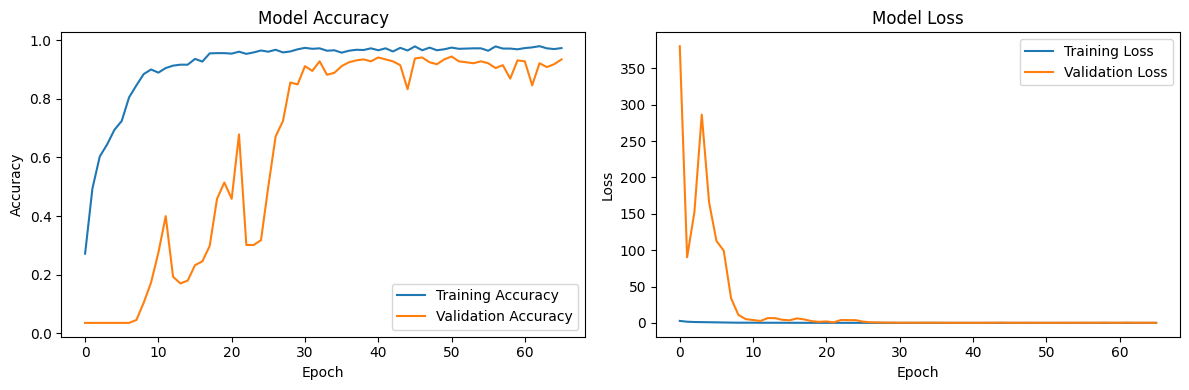

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_training_history(history):

    plt.figure(figsize=(12, 4))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_training_history(history)

# Confusion Matrix

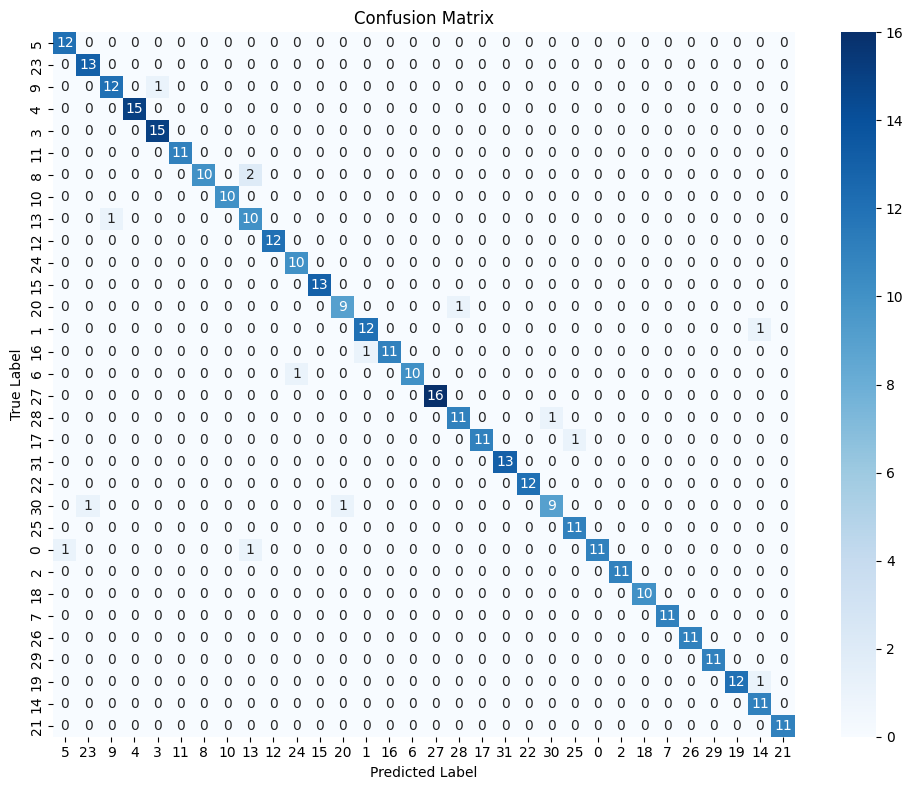

In [54]:
def plot_confusion_matrix(y_true, y_pred, class_names):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, class_names)

# Precision_recall

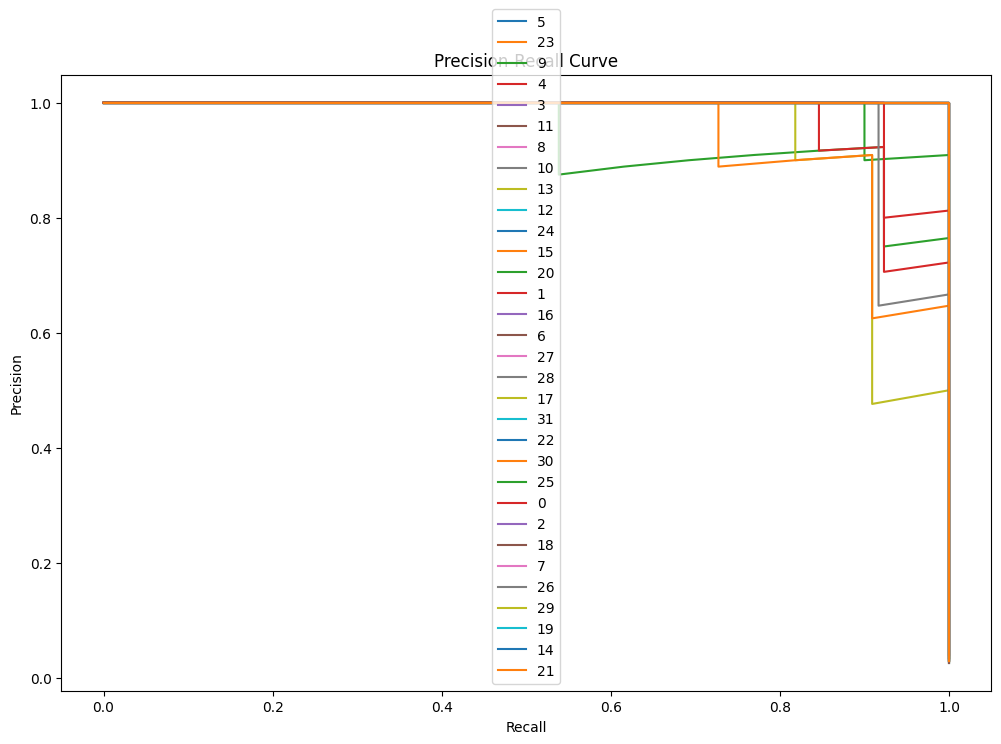

In [55]:
def plot_precision_recall_curve(y_true_onehot, y_pred_proba, class_names):

    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(
            y_true_onehot[:, i], 
            y_pred_proba[:, i]
        )
        plt.plot(recall, precision, label=f'{class_names[i]}')
    
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()

plot_precision_recall_curve(y_test_onehot, y_pred_proba, class_names)

# Roc

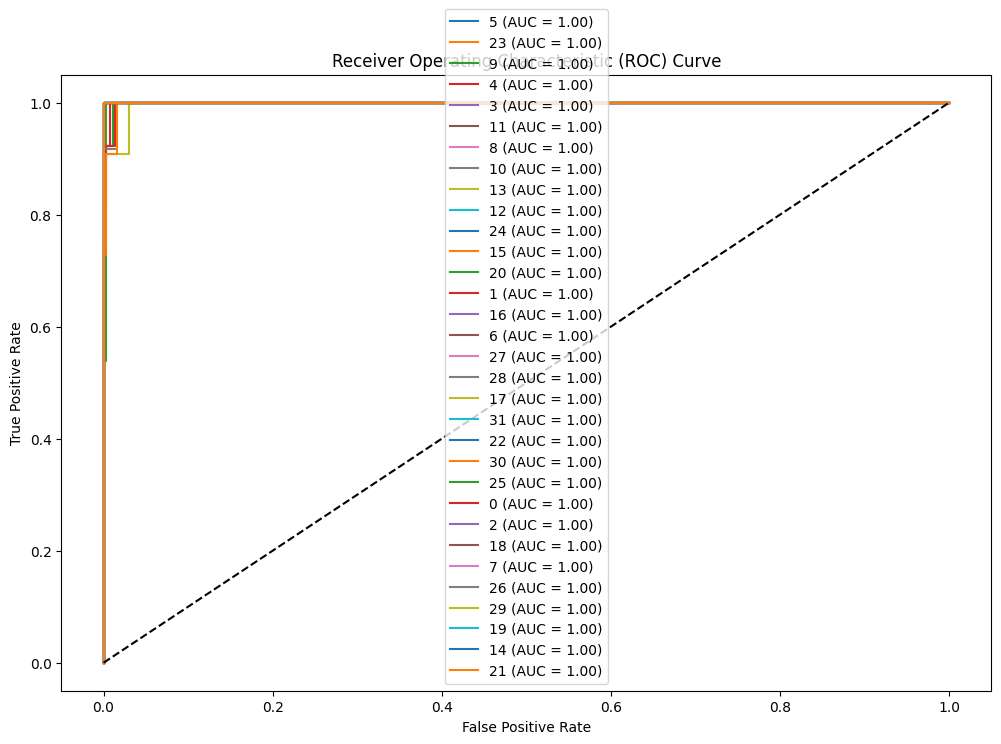

In [56]:
def plot_roc_curve(y_true_onehot, y_pred_proba, class_names):

    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(
            y_true_onehot[:, i], 
            y_pred_proba[:, i]
        )
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.show()


plot_roc_curve(y_test_onehot, y_pred_proba, class_names)